In [1]:
# Run these lines only the first time you run this notebook

# !pip install tensorflow_addons gdown shap -q
# !pip install git+https://github.com/katarinagresova/DeepExperiment

# !wget https://github.com/ML-Bioinfo-CEITEC/miRBind/raw/main/Models/miRBind.h5
# !wget https://raw.githubusercontent.com/ML-Bioinfo-CEITEC/miRBind/graphs/Datasets/evaluation_set_1_1_CLASH2013_paper.tsv

In [2]:
# import tensorflow

In [3]:
# tensorflow.__version__

In [4]:
from pytorch_lightning.loggers import CometLogger

### Load and preprocess the transcript data

In [5]:
from Bio import SeqIO
import re

def extract_gene_symbol(record):
    tmp = [re.findall("\((.*?)\)", x) for x in record.description.split()]
    while([] in tmp):
        tmp.remove([])
    return tmp[0][0]

gene_symbol_to_seq = {}
file_path = 'data/GCF_000001405.40/rna.fna'

for record in SeqIO.parse(file_path, "fasta"):
    description = record.description.split()
    gene_id = next((item.split('=')[1] for item in description if item.startswith('gene=')), None)
    
    symbol = extract_gene_symbol(record)
    # Do not need the locus tag (== record.id) for now
    # gene_symbol_to_seq[symbol] = [record.seq, record.id]
    gene_symbol_to_seq[symbol] = record.seq    

In [6]:
len(gene_symbol_to_seq.items())

42423

### Get our deep learning model and miRNA data

In [7]:
import numpy as np
import pandas as pd
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers
# from tensorflow.keras.utils import register_keras_serializable
# import tensorflow_addons as tfa
# import cv2 
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm
# from textwrap import wrap
import random
# import shap
# from shap.plots.colors import red_transparent_blue

# from deepexperiment.alignment import Attrament
# from deepexperiment.visualization import plot_alignment, plot_miRNA_importance, plotbar_miRNA_importance
# from deepexperiment.utils import one_hot_encoding, one_hot_encoding_batch
# from deepexperiment.interpret import DeepShap

In [8]:
random.seed(42)

In [9]:
# """# Loading model and the data"""

# model = keras.models.load_model("miRBind.h5")
# # model.summary()

samples = pd.read_csv('evaluation_set_1_1_CLASH2013_paper.tsv', sep='\t')
samples.head()

# # get the miRNAs
# #     CHANGE choose the miRNA
# # miRNA = samples['miRNA'].value_counts().index[6]
# # miRNA

,miRNA,gene,label
0,TAGGTAGTTTCATGTTGTTG,AGACCAGCAACAAACTACCAACACTGTAGAGGAGCCCCTGGATCTT...,1
1,GCAGTCCATGGGCATATACA,CAGCCAAGCCCAGGCTCGCAGTATCAATAAAGCAGTTCTCTGAGGA...,1
2,CAAAGTGCTTACAGTGCAGG,TGAGAACACTTAAAGTTCAAATAGAAATCATTTCTGAAGACAAAAG...,1
3,GAGGGTTGGGTGGAGGCTCT,AATGCCCCAAAATCCAAACCTTCCTGAACGCTATGACACCATGAGT...,1
4,ACTGCCCTAAGTGCTCCTTC,AAGAAACTAGGAGAATGGGTAGGCCTTTGTAAAATTGACAGAGAGG...,1


### Get the scores for FC comparison using files from Bartel  

In [10]:
mirna_FCs = pd.read_csv('modules/evaluation/mirna_fcs.csv',index_col=0, header=0, sep=',')

In [11]:
# mirna_FCs
mirna_FCs['Gene symbol']

RefSeq ID
NM_000017       ACADS
NM_000019       ACAT1
NM_000021       PSEN1
NM_000023        SGCA
NM_000027         AGA
               ...   
NM_213646        WARS
NM_213647       FGFR4
NM_213649       SFXN4
NM_213651    SLC25A24
NM_213662       STAT3
Name: Gene symbol, Length: 8372, dtype: object

In [12]:
def rna_to_dna(rna_sample):
    rna_dic = {
        'A':'A',
        'C':'C',
        'U':'T',
        'G':'G',
    }
    converted = [rna_dic[x.upper()] for x in rna_sample]
    new = ""
    # traverse in the string
    for x in converted:
        new += x
    # return string
    return new

In [13]:
mirna_sequences = ['UAGCAGCACGUAAAUAUUGGCG', 'UAAAGUGCUGACAGUGCAGAU', 'UAACACUGUCUGGUAACGAUGU', 'UAAUACUGCCUGGUAAUGAUGA', 'AUGACCUAUGAAUUGACAGAC', 'UGAGGUAGUAGGUUGUAUGGUU', 'AGCAGCAUUGUACAGGGCUAUGA']
mirna_sequences = [rna_to_dna(x) for x in mirna_sequences]
print(mirna_sequences)

['TAGCAGCACGTAAATATTGGCG', 'TAAAGTGCTGACAGTGCAGAT', 'TAACACTGTCTGGTAACGATGT', 'TAATACTGCCTGGTAATGATGA', 'ATGACCTATGAATTGACAGAC', 'TGAGGTAGTAGGTTGTATGGTT', 'AGCAGCATTGTACAGGGCTATGA']


In [14]:
miRNA_names = ['hsa-miR-16-5p', 'hsa-miR-106b-5p', 'hsa-miR-200a-3p', 'hsa-miR-200b-3p', 'hsa-miR-215-5p', 'hsa-let-7c-5p', 'hsa-miR-103a-3p']
miRNA_name_to_seq = {}
for i in range(len(miRNA_names)):
    miRNA_name_to_seq[miRNA_names[i]] = mirna_sequences[i]
miRNA_name_to_seq

{'hsa-miR-16-5p': 'TAGCAGCACGTAAATATTGGCG',
 'hsa-miR-106b-5p': 'TAAAGTGCTGACAGTGCAGAT',
 'hsa-miR-200a-3p': 'TAACACTGTCTGGTAACGATGT',
 'hsa-miR-200b-3p': 'TAATACTGCCTGGTAATGATGA',
 'hsa-miR-215-5p': 'ATGACCTATGAATTGACAGAC',
 'hsa-let-7c-5p': 'TGAGGTAGTAGGTTGTATGGTT',
 'hsa-miR-103a-3p': 'AGCAGCATTGTACAGGGCTATGA'}

#### Only for 1 miRNA now 

In [15]:
mirna_sequences = ['TAAAGTGCTGACAGTGCAGAT']
mirna_sequences
mirna_name = 'hsa-miR-106b-5p'
# mirna_name = 'hsa-miR-16-5p'
my_miRNA = 'TAAAGTGCTGACAGTGCAGAT'
# my_miRNA = 'TAGCAGCACGTAAATATTGGCG'

In [16]:
gene_symbols = mirna_FCs[mirna_FCs[mirna_name].isnull() == False]['Gene symbol'].values
print(len(gene_symbols))

8092


#### Load the explainability scoring to a file

In [17]:
import json

save_scores_path = "explainability_scores_{}.json".format(mirna_name)

#### Load the explainability scoring

In [18]:
load_scores_path = save_scores_path

with open(load_scores_path, 'r') as file:
    miRNA_to_gene_score_loaded = json.load(file)

In [19]:
print(type(miRNA_to_gene_score_loaded), type(miRNA_to_gene_score_loaded[my_miRNA]))

<class 'dict'> <class 'list'>


In [20]:
print(miRNA_to_gene_score_loaded[my_miRNA][0][0])

A2M


In [21]:
loaded_genes = [x[0] for x in miRNA_to_gene_score_loaded[my_miRNA]]

### Plot

In [22]:
def get_islands(arr):
    # Find start and end+1 of each island
    starts = np.array([], int)
    ends = np.array([], int)
    for i in range(len(arr)-1):        
        if arr[i] == 0 and arr[i+1] != 0 or i==0 and arr[i] != 0:
            # starts.append(i+1)
            starts = np.append(starts, i+1)
        if arr[i] != 0 and arr[i+1] == 0:
            # or arr[i] != 0 and len(arr) == i
            # ends.append(i)
            ends = np.append(ends, i+1)

    # Get lengths of each island
    lengths = ends - starts

    # Return as pairs of (start, length)
    # return list(zip(starts, ends, lengths))
    return (starts, ends, lengths)

idxes = [] 
for i in [1, 6, 19]:
    idxes.append(get_islands(miRNA_to_gene_score_loaded[my_miRNA][i][1]))
    

In [23]:
print(miRNA_to_gene_score_loaded[my_miRNA][19][1][idxes[2][0][0]-1 : idxes[2][1][0]+1])

[0.0, 6.660619284957647e-05, 9.951850399374961e-05, 0.0003023144789040089, 0.00014385688118636608, 0.00025316121056675914, 0.0002203066274523735, 0.0021231752634048463, 0.0026548716425895693, 0.0004114201292395592, 0.0006678072363138199, 0.001579331474031278, 0.0008955527911894024, 0.001183917294256389, 0.001704848101362586, 0.0010069606266915798, 0.002865324360318482, 0.0012442029174417257, 0.0008290026636677794, 0.0015094609186053277, 0.00041354633285664024, 0.0015391211956739426, 0.0017147809267044067, 0.00025641327840276063, 0.0001803998585091904, 9.855834767222405e-05, 9.49101964943111e-05, 0.00012953354278579353, 4.004052258096635e-05, 8.373179472982884e-05, 6.380955455824733e-05, 4.151891625951976e-05, 9.057046379894018e-05, 6.791138206608593e-05, 7.710815290920436e-05, 0.00010695577890146524, 4.696741001680493e-05, 9.77395661175251e-05, 4.539894638583064e-05, 5.431550554931164e-05, 3.226074069971219e-05, 5.066958954557777e-05, 4.7975672059692444e-05, 6.335656566079706e-05, 3.13

In [24]:
#starts
for k in idxes[2][0]:
    print(miRNA_to_gene_score_loaded[my_miRNA][19][1][k])
    
#ends
for k in idxes[2][1]:
    print(miRNA_to_gene_score_loaded[my_miRNA][19][1][k-1])

6.660619284957647e-05
1.878536073490977e-05
1.2466057669371366e-05
8.602754678577185e-07
1.037647743942216e-06
7.927888509584591e-07


In [25]:
binding_sites = []

for scores in miRNA_to_gene_score_loaded[my_miRNA]:
    binding_sites.append(get_islands(scores[1]))

len(binding_sites)

42402

In [26]:
len(miRNA_to_gene_score_loaded[my_miRNA])

42402

### Count the statistics for input data

In [27]:
from modules.collect_scores.bymaxvalue import bymaxvaluefunc
from modules.collect_scores.bymean import bymeanfunc


input_data = []
input_data_genes = []
transcripts_with_no_bs = []
FEATURES = [0, 1, 2, 3]
FEATURE_NAMES = ['max', 'mean', 'bs_start', 'transcript_len']


scores_per_gene = miRNA_to_gene_score_loaded[my_miRNA]

statistical_funcs = [bymaxvaluefunc, bymeanfunc]
# and starting index

# for each gene
for i in range(len(scores_per_gene)):
    scores = scores_per_gene[i][1]
    gene_name = scores_per_gene[i][0]
    seq_binding = []
    starts, ends, lengths = binding_sites[i]
    
    # for each binding site: count features
    for k in range(len(starts)):
        
        if starts[k].any():
        # if start.size > 0:
            # this dictates the number of features
            stat_one = statistical_funcs[0](scores[starts[k]:ends[k]])
            stat_two = statistical_funcs[1](scores[starts[k]:ends[k]])
            # TODO think about the modeling of input data because now the " len(scores)" is the same number in every binding site (quartet) of single transcript
            seq_binding.append([stat_one, stat_two, starts[k], len(scores)])
        else:
            seq_binding.append([0, 0, 0, 0])
            
    if len(seq_binding) > 0:
        input_data.append(seq_binding)
        input_data_genes.append(gene_name)
    else:
        transcripts_with_no_bs.append(gene_name)

In [28]:
len(input_data), input_data[6],  input_data[1],  input_data[4]

(25629,
 [[0.00031168844550848006, 4.931571403139971e-05, 1090, 1431]],
 [[0.0020709490776062013, 0.0002585863833349625, 1300, 1521]],
 [[0.000854843556880951, 0.00011655626766732893, 2340, 4244],
  [0.0004107185825705528, 6.734315702051388e-05, 4090, 4244]])

In [29]:
start, end, length = binding_sites[0]
print(start, end, length)
type(start)

[860] [910] [50]


numpy.ndarray

In [30]:
len(binding_sites[3])

3

In [31]:
bs_count = []
for i in input_data:
    # if 
    bs_count.append(len(i))

### Number of binding sites per transcript


OrderedDict([(0, 16773), (1, 10378), (2, 5922), (3, 3445), (4, 2088), (5, 1250), (6, 761), (7, 498), (8, 346), (9, 225), (10, 145), (11, 138), (12, 93), (13, 53), (14, 60), (15, 40), (16, 32), (17, 21), (18, 15), (19, 11), (20, 11), (21, 13), (22, 5), (23, 9), (24, 6), (25, 9), (26, 3), (27, 10), (28, 5), (29, 6), (30, 6), (31, 2), (32, 2), (33, 2), (34, 2), (35, 3), (36, 1), (37, 2), (38, 1), (44, 2), (45, 2), (48, 1), (53, 1), (62, 1), (64, 1), (65, 1), (66, 1)])


<BarContainer object of 47 artists>

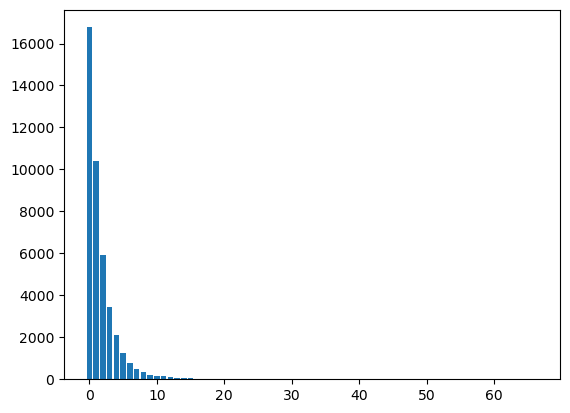

In [32]:
import  collections
import matplotlib.pyplot as plt
w = collections.Counter(bs_count)
w[0] = len(transcripts_with_no_bs)
w = collections.OrderedDict(sorted(w.items()))
print(w)
plt.bar(w.keys(), w.values())

# plt.figure(num = random.randint(0, 1000)) # num is a unique identifier for the figure
# plt.plot(collections.Counter(bs_count));

### Normalize input data

#### TODO should we do some more complex normalization/preprocessing based on the shape/statistics of the data? --- a lot of low values; take outliers into acount when choosing normalization method?

In [33]:
input_data[5], input_data[1]

([[0.0005550672113895416, 7.100176308886147e-05, 450, 5961],
  [0.0003475658968091011, 7.346505898676696e-05, 1230, 5961],
  [0.00019479231908917427, 3.8508949094102705e-05, 2010, 5961],
  [0.0016985791968181728, 0.0002653615775329855, 2560, 5961],
  [0.0011792104318737984, 0.0001531407045658853, 2650, 5961],
  [0.0003918356075882912, 6.104532821627802e-05, 5400, 5961]],
 [[0.0020709490776062013, 0.0002585863833349625, 1300, 1521]])

In [34]:
feature_maxmins = {}

for feature in FEATURES:
    x_min = 999999
    x_max = -1
    for sample in input_data:
        for binding_site in sample:
            item = binding_site[feature]
            if x_min > item:
                x_min = item
            if x_max < item:
                x_max = item
    
    feature_maxmins['feature' + str(feature)] = (x_min, x_max)
    
print("maxes and mins")
feature_maxmins

maxes and mins


{'feature0': (0.0001069104764610529, 0.4938503155484796),
 'feature1': (2.6173551956890148e-05, 0.0348073390016565),
 'feature2': (1, 100270),
 'feature3': (58, 100785)}

In [99]:
input_data_normalized = []

for sample in input_data:
    new_sample = []
    for binding_site in sample:
        new_binding_site = []
        for feature in FEATURES:
            x_min = list(feature_maxmins.items())[feature][1][0]
            x_max = list(feature_maxmins.items())[feature][1][1]
            item = binding_site[feature]
            item = (item - x_min) / (x_max - x_min)
            new_binding_site.append(item)
        new_sample.append(new_binding_site)
    input_data_normalized.append(new_sample)    

In [100]:
print(input_data_normalized[5])
print(input_data_normalized[1])

[[0.0009076713335808902, 0.0012888645493148213, 0.004477954302925131, 0.05860394928867136], [0.0004874098932277296, 0.0013596872450484618, 0.012257028593084602, 0.05860394928867136], [0.00017799091942362802, 0.00035465738360757233, 0.02003610288324407, 0.05860394928867136], [0.00322367590940269, 0.006876941082437509, 0.02552134757502319, 0.05860394928867136], [0.0021717757531492243, 0.003650457107097649, 0.02641893307004159, 0.05860394928867136], [0.0005770712645481887, 0.001002605168875646, 0.053845156528937156, 0.05860394928867136]]
[[0.003977852829970801, 0.006682146166556348, 0.01295515064476558, 0.014524407557060172]]


### Explore input features distribution

In [101]:
features_grouped = [[] for x in FEATURES]
for sample in input_data:
    for binding_site in sample:
        for index in FEATURES:    
            features_grouped[index].append(binding_site[index])
            
features_grouped_normalized = [[] for x in FEATURES]
for sample in input_data_normalized:
    for binding_site in sample:
        for index in FEATURES:    
            features_grouped_normalized[index].append(binding_site[index])


In [146]:
import matplotlib.pyplot as plt
import seaborn as sns

def multi_bar_plot(data):
    sns.set_style('whitegrid')
    g = sns.catplot(x="signal values", y="counts",
                    # col="year",
                    data=data,
                    kind="bar", height=3, aspect=.7, palette='viridis')
    print(data)
    for ax in g.axes.flat[1:]:
        sns.despine(ax=ax, left=True)
    for ax in g.axes.flat:
        ax.set_xlabel(ax.get_title())
        ax.set_title('')
        ax.margins(x=0.03)
        ax.tick_params(axis='x', labelrotation=90)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0)
    plt.show()

In [147]:
# sns.load_dataset("flights")

['max', 'mean', 'bs_start', 'transcript_len']
     signal values  counts
0           0.4939       1
1           0.4931       1
2           0.4532       1
3           0.4466       1
4           0.2438       1
..             ...     ...
375         0.0005    7963
376         0.0004    9081
377         0.0003    6832
378         0.0002    1685
379         0.0001      24

[380 rows x 2 columns]


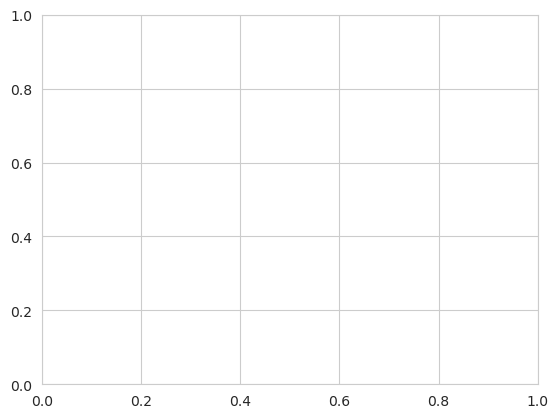

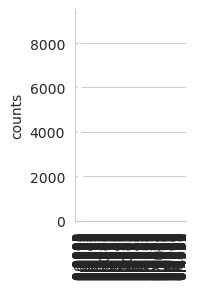

     signal values  counts
0           0.0348       1
1           0.0337       1
2           0.0304       2
3           0.0302       1
4           0.0234       1
..             ...     ...
104         0.0004     835
105         0.0003    4544
106         0.0002   15956
107         0.0001   43048
108         0.0000    4776

[109 rows x 2 columns]


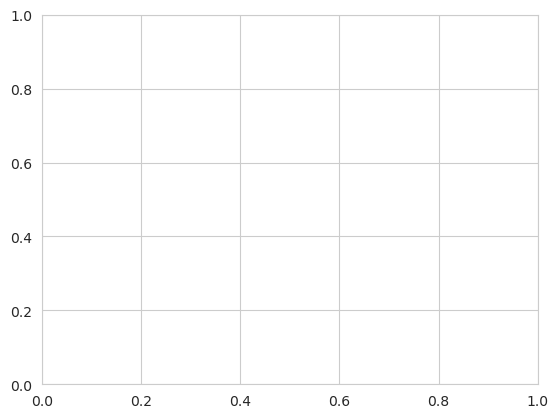

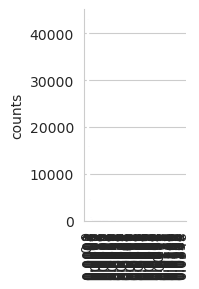

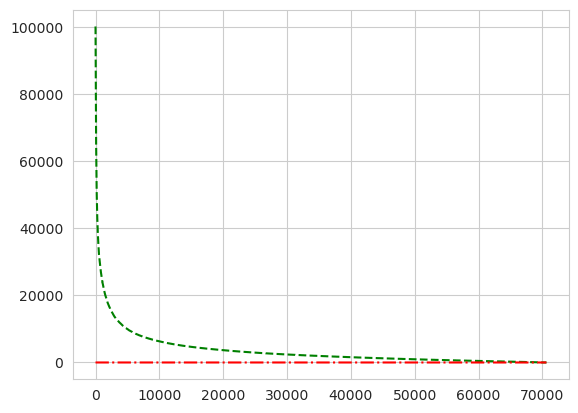

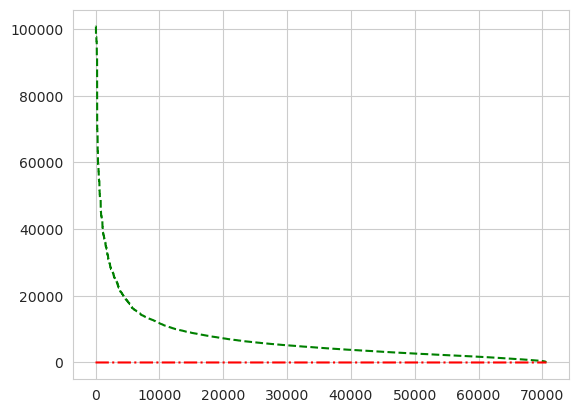

In [148]:
from collections import Counter
print(FEATURE_NAMES)

for i in FEATURES:
    features_grouped[i].sort(reverse=True)
    features_grouped_normalized[i].sort(reverse=True)

for i in [0,1]:
    ax = plt.gca()
    # ax.set_xlim([-1, 1000])
    # ax.set_ylim([ymin, ymax])
    plt.grid(visible=True)
    #____
    rounded = [ round(elem, 4) for elem in features_grouped[i]]
    w = Counter(rounded)
    multi_bar_plot(
        pd.DataFrame(list(zip(w.keys(), w.values())),
        columns =['signal values', 'counts'])
    )    
    # plt.bar(w.keys(), w.values())
    #____
    # plt.plot(features_grouped[i],'g--', label="raw")
    # plt.plot(features_grouped_normalized[i],'r-.', label="normalized")
    #____
    # plt.plot(features_grouped[i], features_grouped_normalized[i])
    #____
    # plt.ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax))
    # plt.show()
    
for i in [2,3]:
    ax = plt.gca()
    # ax.set_xlim([-1, 11000])
    # ax.set_ylim([ymin, ymax])
    plt.grid(visible=True)
    plt.plot(features_grouped[i],'g--', label="raw")
    plt.plot(features_grouped_normalized[i],'r-.', label="normalized")
    # plt.plot(features_grouped[i], features_grouped_normalized[i])
    # plt.ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax))
    plt.show()

### Padding input data to 10 binding sites per sample

In [37]:
print(len(input_data_normalized))
print(input_data_normalized[4])

flatten_input = []
for sample in input_data_normalized:
    flatten_sample = []
    for bs in sample:
        flatten_sample.extend(bs)
    flatten_input.append(flatten_sample)

25629
[[0.0015148214087250499, 0.0025986109016717662, 0.023327249698311542, 0.04155787425417217], [0.0006153157753371628, 0.0011836752601968746, 0.040780300990336, 0.04155787425417217]]


In [38]:
print(len(flatten_input))
print(flatten_input[4])

25629
[0.0015148214087250499, 0.0025986109016717662, 0.023327249698311542, 0.04155787425417217, 0.0006153157753371628, 0.0011836752601968746, 0.040780300990336, 0.04155787425417217]


In [39]:
import torch
import torch.nn.functional as F

# Convert to tensor
data_tensor = torch.nn.utils.rnn.pad_sequence([torch.tensor(item) for item in flatten_input], batch_first=True)

# Calculate the padding required
padding = (0, (len(FEATURES) * 10) - data_tensor.size(1))

# Pad with zeros
padded_data_tensor = F.pad(data_tensor, padding, value=0)

In [40]:
len(padded_data_tensor), padded_data_tensor[0].size(), padded_data_tensor[0]

(25629,
 torch.Size([40]),
 tensor([0.0015, 0.0022, 0.0086, 0.0486, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000], dtype=torch.float64))

### Add labels

In [41]:
# input_data_genes

mirna_FCs = pd.read_csv('mirna_fcs.csv',index_col=0, header=0, sep=',')
# mirna_FCs[['Gene symbol',my_miRNA_name]]

mirna_FCs_dict = mirna_FCs.set_index('Gene symbol')['hsa-miR-106b-5p'].to_dict()
# df_dict

input_labels_unfiltered = []
not_found_genes = []
gene_indices_to_remove = []
nan_genes = []

for i, gene in enumerate(input_data_genes):
    try:
        fc = mirna_FCs_dict[gene]
        if np.isnan(fc):
            nan_genes.append(gene)
            input_labels_unfiltered.append(0)
            gene_indices_to_remove.append(i)            
        else:
            input_labels_unfiltered.append(fc)
    except:
        not_found_genes.append(gene)
        input_labels_unfiltered.append(0)
        gene_indices_to_remove.append(i)

In [42]:
"There is ", len(not_found_genes), "genes for which we do not have fold change because they are not in the Bartel table, out of total", len(input_labels_unfiltered), "and", len(nan_genes), "nan valued genes in FC table"

('There is ',
 20167,
 'genes for which we do not have fold change because they are not in the Bartel table, out of total',
 25629,
 'and',
 171,
 'nan valued genes in FC table')

### Filter genes without fold change from the dataset

In [43]:
num_genes = len(input_data_genes)

for i in gene_indices_to_remove:
    input_labels_unfiltered[i] = "remove"

input_labels =  [i for i in input_labels_unfiltered if i != "remove"]
padded_data_tensor =  [padded_data_tensor[i] for i in range(len(input_labels_unfiltered)) if input_labels_unfiltered[i] != "remove"]
input_data_genes_filtered = [input_data_genes[i] for i in range(len(input_labels_unfiltered)) if input_labels_unfiltered[i] != "remove"]

In [44]:
len(input_labels), len(padded_data_tensor)

(5291, 5291)

In [58]:
for i in range(10):
    print(padded_data_tensor[i])


tensor([0.0017, 0.0028, 0.0145, 0.0192, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000], dtype=torch.float64)
tensor([0.0042, 0.0071, 0.0013, 0.0146, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000], dtype=torch.float64)
tensor([0.0009, 0.0013, 0.0045, 0.0586, 0.0005, 0.0014, 0.0123, 0.0586, 0.0002,
        0.0004, 0.0200, 0.0586, 0.0032, 0.0069, 0.0255, 0.0586, 0.0022, 0.0037,
        0.0264, 0.0586, 0.0006, 0.0010, 0.0538, 0.0586, 0.0000, 0.0000, 0.00

### Split train/validation/test

#### Create test set based on what genes we can compare on with Bartel

In [49]:
targetscan = pd.read_csv('Predicted_Targets_Context_Scores.default_predictions.txt',index_col=0, header=0, sep='\t')
targetscan = targetscan[["context++ score","weighted context++ score","miRNA","Gene Symbol"]]
targetscan = targetscan[targetscan['miRNA'] == mirna_name]

bartel_gene_names = targetscan['Gene Symbol'].to_numpy().flatten()

bartel_test_samples = set(bartel_gene_names).intersection(
    set(mirna_FCs[["Gene symbol"]].to_numpy().flatten())).intersection(
    set(input_data_genes_filtered))

len(bartel_test_samples)

580

In [50]:
from sklearn.model_selection import train_test_split

BARTEL_SPLIT = True


if BARTEL_SPLIT:
    # x_train, x_test, y_train, y_test = train_test_split(padded_data_tensor, input_labels, test_size=0.2, random_state=42)
    # Split the data and gene names simultaneously
    indecis = []
    x_train, x_test, y_train, y_test, gene_names_train, gene_names_test = [],[],[],[],[],[]
    
    for sample, label, name in zip(padded_data_tensor, input_labels, input_data_genes_filtered):
        if name in bartel_test_samples:
            x_test.append(sample)
            y_test.append(label)
            gene_names_test.append(name)
        else:
            x_train.append(sample)
            y_train.append(label)
            gene_names_train.append(name)
    print(len(x_train), len(x_test))

    # validation
    x_train, x_val, y_train, y_val, gene_names_train, gene_names_val = train_test_split(x_train, y_train, gene_names_train, test_size=0.1, random_state=42)

    print(len(y_train), len(y_val), len(y_test))
    print(len(gene_names_train), len(gene_names_val), len(gene_names_test))
else:
    # x_train, x_test, y_train, y_test = train_test_split(padded_data_tensor, input_labels, test_size=0.2, random_state=42)
    # Split the data and gene names simultaneously
    (x_train, x_test, y_train, y_test, gene_names_train, gene_names_test) = train_test_split(
        padded_data_tensor, input_labels, input_data_genes_filtered, test_size=0.2, random_state=42)

        #validation
    x_train, x_val, y_train, y_val, gene_names_train, gene_names_val = train_test_split(x_train, y_train, gene_names_train, test_size=0.1, random_state=42)

    print(len(y_train), len(y_val), len(y_test))
    print(len(gene_names_train), len(gene_names_val), len(gene_names_test))


4711 580
4239 472 580
4239 472 580


### Make a datasets


In [51]:
from torch.utils.data import Dataset, DataLoader, TensorDataset


test_dataset = TensorDataset(torch.stack(x_test).unsqueeze(1).float(), torch.tensor(y_test).unsqueeze(dim=1))
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


class TrainDataset(Dataset):
    def __init__(self, data, labels, exps):
        self.data = data
        self.labels = labels
        self.exps = exps

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.labels[idx]
        exp = self.exps[idx]
        return x, y, exp
    
class ValDataset(Dataset):
    def __init__(self, data, labels, identifiers):
        self.data = data
        self.labels = labels
        self.identifiers = identifiers

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.labels[idx]
        identifier = self.identifiers[idx]
        return x, y, identifier

#dummy exps and indentifiers
exps = [1 for x in range(len(y_train))]
identifiers = []
for label in y_val:
    item = {}
    item['readid']=0
    item['label']=label
    item['exp']=1
    identifiers.append(item)


train_dataset = TrainDataset(torch.stack(x_train).unsqueeze(1).float(), torch.tensor(y_train).unsqueeze(dim=1), exps)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = ValDataset(torch.stack(x_val).unsqueeze(1).float(), torch.tensor(y_val).unsqueeze(dim=1), identifiers)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [52]:
np.count_nonzero(np.isnan(y_train)), np.count_nonzero(~np.isnan(y_train))

(0, 4239)

### Set up logging

In [53]:
comet_logger = CometLogger(
    api_key="EpKIINrla6U4B4LJhd9Sv4i0b",
    project_name="mirna",
)

CometLogger will be initialized in online mode


### Train a simple network 

In [54]:
import torch
import torchmetrics
import pytorch_lightning as pl
from types import SimpleNamespace
import numpy as np
import re
from sklearn.metrics import roc_auc_score
from collections import defaultdict
from modules.models.modules import ConvNet, RNNEncoder, MLP, Attention, Permute, SimpleCNN # , BigConvNet, ResConvNet
from sklearn.metrics import average_precision_score
import csv


class Small_CNN(pl.LightningModule):
    def __init__(
            self,
            pooling='max',
            lr=1e-3,
            warmup_steps=100,
            wd=0.01,
            logging_steps=1,
            pos_weight=1.0,
    ):

        super().__init__()
        self.lr = lr
        self.wd = wd
        self.warmup_steps=warmup_steps

        if(pooling=='rnn'):
            self.architecture = torch.nn.Sequential(
                SimpleCNN(num_layers=1),
                Permute(),
                RNNEncoder(input_size=8, hidden_size=16, num_layers=1, dropout=0.2),
                MLP(input_size=96, hidden_size=30),
            )
        if(pooling=='att'):
            self.architecture = torch.nn.Sequential(
                SimpleCNN(num_layers=1),
                Permute(),
                Attention(input_dim=8, len_limit=400000),
                MLP(8, 30),
            )
        if(pooling=='max'):
            self.architecture = torch.nn.Sequential(
                SimpleCNN(num_layers=1),
                torch.nn.AdaptiveMaxPool1d(1),
                torch.nn.Flatten(),
                MLP(8, 30),
            )

        # self.acc = torchmetrics.classification.Accuracy(task="binary")
        # self.ce = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_weight]).to(self.device))
        self.ce = torch.nn.MSELoss()
            
        # Logging utils to fix, TODO resolve with a custom callback?
        self.training_step_counter = 0
        self.cumulative_loss = 0
        self.cumulative_acc = 0
        self.logging_steps = logging_steps
        
        self.mae = torchmetrics.MeanAbsoluteError()
        self.mse = torchmetrics.MeanSquaredError()
        self.r2 = torchmetrics.R2Score()

    def forward(self, x):
        return self.architecture(x)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
            params=self.parameters(), 
            lr=self.lr, 
            weight_decay=self.wd
        )
        scheduler = torch.optim.lr_scheduler.LinearLR(
            optimizer, 
            total_iters=self.warmup_steps
        )
        return [optimizer], [scheduler]

    def training_step(self, train_batch, batch_idx, dataloader_idx=None):
        x, y, exp = train_batch
        logits = self(x)
        loss = self.ce(logits, y)
        
        self.log('train_loss', loss, on_epoch=True, on_step=False)
        probs = self.logits_to_probs(logits)
        
        metrics = self.get_metrics(probs, y, exp)
        self.log_cumulative_train_metrics(loss, metrics['mse'])
        for metric, value in metrics.items():
            self.log(f'train {metric}', value, on_epoch=True, on_step=False)
        
        # print("Logits:", logits)
        # print("Labels:", y)
        # print("Loss:", loss)

        self.lr_schedulers().step()
        return loss
    
    def validation_step(self, val_batch, batch_idx, dataloader_idx=None):
        x, y, identifier = val_batch
        exp = identifier['exp']
        logits=self(x)
        loss = self.ce(logits, y)
        
        self.log('valid_loss', loss, on_epoch=True, on_step=False)
        probs = self.logits_to_probs(logits)
        metrics = self.get_metrics(probs, y, exp)
        for metric, value in metrics.items():
            self.log(f'valid {metric}', value, on_epoch=True, on_step=False)
            
        return {
            'preds': probs.detach().cpu().numpy(), 
            'identifier': {
                'readid':identifier['readid'],
                'label':identifier['label'].detach().cpu(),
                'exp':identifier['exp'],
            }
        }

    
    def predict_step(self, batch, batch_idx):
        xs, ids = batch
        logits = self.forward(xs)
        res = self.logits_to_probs(logits)
        return res, ids
    
    def get_metrics(self, predictions, labels, exps):
        metrics = {}
        
        mse = self.mse(predictions, labels)
        mae = self.mae(predictions, labels)
        r2 = self.r2(predictions, labels)
        rmse = torch.sqrt(mse)

        metrics['mse'] = mse
        metrics['mae'] = mae
        metrics['r2'] = r2
        metrics['rmse'] = rmse
        
        # exps = np.array(exps)
        # for e in np.unique(exps):
        #     indices = exps == e
        #     if (sum(indices) > 0): #If Non-empty
        #         metrics[f'{e} acc'] = self.acc(predictions[exps == e], labels[exps == e])
        return metrics

    def log_cumulative_train_metrics(self, loss, accuracy):
        self.training_step_counter += 1
        self.cumulative_loss += loss.item()
        self.cumulative_acc += accuracy

        if self.training_step_counter % self.logging_steps == 0:
            avg_loss = self.cumulative_loss / self.logging_steps
            avg_acc = self.cumulative_acc / self.logging_steps
            
            self.log(f'train_loss_cum', avg_loss, on_step=True, on_epoch=False)
            self.log(f'train_acc_cum', avg_acc, on_step=True, on_epoch=False)
            self.cumulative_acc = 0
            self.cumulative_loss = 0
            
    def logits_to_probs(self, logits):
        # return torch.sigmoid(logits)
        return logits
    

    def validation_epoch_end(self, outputs):
        # Aggregate all validation predictions into auroc metrics
        read_to_pred, read_to_label, read_to_exp = self.aggregate_outputs(outputs)

        print(f"\n Validation Metrics: MSE={self.mse.compute()}, MAE={self.mae.compute()}, R2={self.r2.compute()}, RMSE={torch.sqrt(self.mse.compute())}")
        with open('validation_metrics.csv', mode='a') as file:
            writer = csv.writer(file)
            writer.writerow([self.mse.compute().item(), self.mae.compute().item(), self.r2.compute().item(), torch.sqrt(self.mse.compute()).item()])
    
        # reset metrics (important for next epoch)
        self.mse.reset()
        self.mae.reset()
        self.r2.reset()

    def aggregate_outputs(self, outputs):
        read_to_preds = {}
        read_to_label = {}
        read_to_exp = {}
        for log in outputs:
            preds = log['preds']#.cpu().numpy()
            ids = log['identifier']

            for i, (readid, pred, label, exp) in enumerate(zip(ids['readid'], preds, ids['label'], ids['exp'])):
                read_to_label[readid] = label
                read_to_exp[readid] = exp
                #TODO remove for optimization
                assert len(pred) == 1 
                read_to_preds[readid] = pred[0]

        return read_to_preds, read_to_label, read_to_exp
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.ce(logits, y)
        metrics = self.get_metrics(logits, y, None)  # Assuming you have a method to calculate metrics
        output = {'test_loss': loss, **metrics}
        return output

    def test_epoch_end(self, outputs):
        avg_loss = torch.stack([x['test_loss'] for x in outputs]).mean()
        avg_metrics = {key: torch.stack([x[key] for x in outputs]).mean() for key in outputs[0].keys() if key != 'test_loss'}
        results = {'test_loss': avg_loss, **avg_metrics}
        self.log_dict(results)


In [52]:
from pytorch_lightning import Trainer
from IPython.utils import io


model = Small_CNN(pooling='att')
# trainer = Trainer(max_epochs=1, gpus=1)  # Use GPU if available, train for X epochs
trainer = Trainer(logger=comet_logger, max_epochs=3)  # Use GPU if available, train for X epochs

with io.capture_output() as captured:
    trainer.fit(model, train_loader, val_loader)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name         | Type              | Params
---------------------------------------------------
0 | architecture | Sequential        | 350   
1 | ce           | MSELoss           | 0     
2 | mae          | MeanAbsoluteError | 0     
3 | mse          | MeanSquaredError  | 0     
4 | r2           | R2Score           | 0     
---------------------------------------------------
350       Trainable params
0         Non-trainable params
350       Total params
0.001     Total estimated model params size (MB)
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET WARNING: You are trying to log string value as a metric. 

### Test

In [53]:
result = trainer.test(model, test_loader)

/home/jovyan/my-conda-envs/deepExpTorch2/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 19/19 [00:00<00:00, 379.47it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/davidcechak/mirna/86f2eec40262412a967fa5dac39d9af8



Testing DataLoader 0: 100%|██████████| 19/19 [00:04<00:00,  3.93it/s] 


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│            mae            │    0.21250438690185547    │
│            mse            │    0.08212340623140335    │
│            r2             │    -0.7337805032730103    │
│           rmse            │    0.2803666591644287     │
│         test_loss         │    0.08212340623140335    │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/davidcechak/mirna/86f2eec40262412a967fa5dac39d9af8
COMET INFO:   Metrics:
COMET INFO:     mae       : 0.21250438690185547
COMET INFO:     mse       : 0.08212340623140335
COMET INFO:     r2        : -0.7337805032730103
COMET INFO:     rmse      : 0.2803666591644287
COMET INFO:     test_loss : 0.08212340623140335
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages


In [54]:
result

[{'test_loss': 0.08212340623140335,
  'mse': 0.08212340623140335,
  'mae': 0.21250438690185547,
  'r2': -0.7337805032730103,
  'rmse': 0.2803666591644287}]

In [55]:
# feature_maxmins, FEATURE_NAMES
# torch.stack(x_test).unsqueeze(1).float(), torch.tensor(y_test).unsqueeze(dim=1)
from statistics import mean

print(mean(y_train), min(y_train), max(y_train))
print(mean(y_test), min(y_test), max(y_test))

# Baseline: mean of the training dataset labels
baseline = mean(y_train)
baseline_mean = torchmetrics.MeanAbsoluteError()(torch.tensor(np.full((len(y_test),), baseline)), torch.tensor(np.array(y_test)))
print('MAE: Our prediction is better by ', baseline_mean.item() - result[0]['mae'], ' our MAE: ', result[0]['mae'], '; mean-baseline MAE: ', baseline_mean.item())

print('Baseline metrics: ')
model.get_metrics(torch.tensor(np.full((len(y_test),), mean(y_train))), torch.tensor(np.array(y_test)), None)

0.015894314696862467 -0.983 0.961
-0.17517241379310344 -1.255 0.397
MAE: Our prediction is better by  0.014813318848609924  our MAE:  0.21250438690185547 ; mean-baseline MAE:  0.2273177057504654
Baseline metrics: 


{'mse': tensor(0.0903),
 'mae': tensor(0.2273),
 'r2': tensor(-0.6784),
 'rmse': tensor(0.3005)}

### Predict

In [56]:
# predictions = model(torch.randn(2, 1, 40))
# trainer.predict(

with torch.no_grad(): # Disables gradient computation, as it's not needed during evaluation
    predictions = model(torch.stack(x_test).unsqueeze(1).float())
print(predictions.squeeze(1).shape)

gene_to_predictions = {}
for i in range(len(gene_names_test)):
    gene_to_predictions[gene_names_test[i]] = predictions.squeeze(1)[i].item()
    
print(list(gene_to_predictions.items())[:2])

predictions_scalar = [x.item() for x in predictions.squeeze(1)]

torch.Size([580])
[('PSEN1', 0.002886563539505005), ('LAMA3', 0.002631787210702896)]


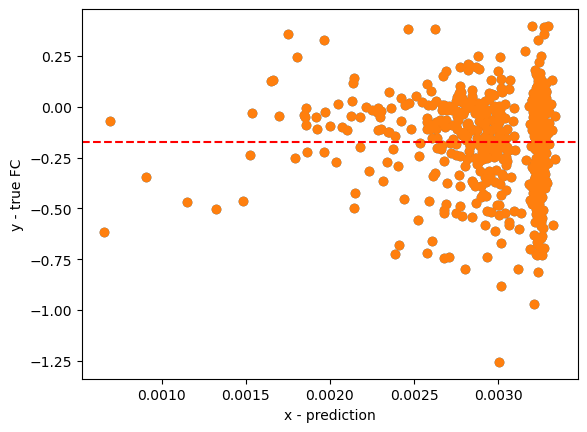

In [57]:
plt.scatter(predictions_scalar, y_test)
plt.scatter(predictions_scalar, y_test)
plt.axhline(y = mean(y_test), color = 'r', linestyle = '--')  
plt.xlabel('x - prediction')
plt.ylabel('y - true FC')
plt.show()

### Bartel metrics 

In [58]:
# targetscan = pd.read_csv('Predicted_Targets_Context_Scores.default_predictions.txt',index_col=0, header=0, sep='\t')
# targetscan = targetscan[["context++ score","weighted context++ score","miRNA","Gene Symbol"]]
# targetscan = targetscan[targetscan['miRNA'] == mirna_name]

# bartel_gene_names = targetscan['Gene Symbol'].to_numpy().flatten()

bartel_gene_to_score = {row[1]: row[0] for row in targetscan[["weighted context++ score", 'Gene Symbol']].to_numpy()}

In [59]:
ordered_bartel_scores = []
for gene in gene_names_test:
    ordered_bartel_scores.append(bartel_gene_to_score[gene])
len(ordered_bartel_scores)

580

In [60]:
bartel_mae = torchmetrics.MeanAbsoluteError()(torch.tensor(ordered_bartel_scores), torch.tensor(np.array(y_test)))
bartel_mse = torchmetrics.MeanSquaredError()(torch.tensor(ordered_bartel_scores), torch.tensor(np.array(y_test)))
bartel_r2 = torchmetrics.R2Score()(torch.tensor(ordered_bartel_scores), torch.tensor(np.array(y_test)))

print('Bartel metrics:')
print('mae', bartel_mae.item())
print('mse', bartel_mse.item())
print('r2', bartel_r2.item())

Bartel metrics:
mae 0.17373275756835938
mse 0.05209270492196083
r2 0.03201955556869507


### Save predictions to be used for 'Top targets plot'


In [61]:
results_df = pd.DataFrame(gene_to_predictions.items(), columns=["Gene Symbol","score"])
results_df

,Gene Symbol,score
0,PSEN1,0.002887
1,LAMA3,0.002632
2,OCRL,0.002878
3,PKD1,0.001847
4,PON2,0.003191
...,...,...
575,TPRG1L,0.003252
576,SPTY2D1,0.002676
577,ZBTB41,0.002669
578,GALNT10,0.003217


In [62]:
file_name = "our_results_df"
results_df.to_pickle(file_name) 
results_df = pd.read_pickle(file_name)

In [63]:
all_genes = []
for gene_symbol, gene_sequence in gene_symbol_to_seq.items():
    all_genes.append(gene_symbol)

#### (prediction) for genes
X axis is different genes, Y axis is fold change

In [64]:
import pandas as pd
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import plotly.io as pio
import plotly.offline as pyo

pio.renderers.default = 'notebook'
pyo.init_notebook_mode(connected=True)


###Importing dummy data
#Predictions
targetscan = pd.read_csv('Predicted_Targets_Context_Scores.default_predictions.txt',index_col=0, header=0, sep='\t')
targetscan = targetscan[["context++ score","weighted context++ score","miRNA","Gene Symbol"]]
targetscan = targetscan[targetscan['miRNA'] == mirna_name]
#Expression
mirna_FCs = pd.read_csv('mirna_fcs.csv',index_col=0, header=0, sep=',')


predictions = {}

predictions["context++ score"] = targetscan[["context++ score","miRNA","Gene Symbol"]]
predictions["context++ score"] = predictions["context++ score"].rename(columns={'context++ score': 'score'})

predictions["weighted context++ score"] = targetscan[["weighted context++ score","miRNA","Gene Symbol"]]
predictions["weighted context++ score"] = predictions["weighted context++ score"].rename(columns={'weighted context++ score': 'score'})

predictions["our score"] = targetscan[["weighted context++ score","miRNA","Gene Symbol"]]
predictions["our score"] = predictions["weighted context++ score"].rename(columns={'weighted context++ score': 'score'})

In [65]:
merged_df = pd.merge(predictions["context++ score"],
                             mirna_FCs[["Gene symbol",mirna_name]],
                             left_on='Gene Symbol',
                             right_on='Gene symbol',
                             how='left').sort_values(mirna_name,
                                                     ascending=True).dropna()
merged_df

,score,miRNA,Gene Symbol,Gene symbol,hsa-miR-106b-5p
311,-0.265,hsa-miR-106b-5p,CYBRD1,CYBRD1,-1.255
1421,-0.300,hsa-miR-106b-5p,TMEM64,TMEM64,-0.971
994,-0.202,hsa-miR-106b-5p,PLEKHM1,PLEKHM1,-0.882
507,-0.229,hsa-miR-106b-5p,FYCO1,FYCO1,-0.814
508,-0.168,hsa-miR-106b-5p,FYCO1,FYCO1,-0.814
...,...,...,...,...,...
362,-0.048,hsa-miR-106b-5p,E2F3,E2F3,0.392
447,-0.029,hsa-miR-106b-5p,FAM84B,FAM84B,0.393
895,-0.010,hsa-miR-106b-5p,OTUD3,OTUD3,0.396
1020,-0.419,hsa-miR-106b-5p,PPP3R1,PPP3R1,0.397


In [66]:
results_df_merged = pd.merge(results_df,
                             mirna_FCs[["Gene symbol",mirna_name]],
                             left_on='Gene Symbol',
                             right_on='Gene symbol',
                             how='left').sort_values(mirna_name,
                                                     ascending=True)
                                                     # ascending=True).dropna()

results_df_merged

,Gene Symbol,score,Gene symbol,hsa-miR-106b-5p
88,CYBRD1,0.003002,CYBRD1,-1.255
26,TMEM64,0.003214,TMEM64,-0.971
345,PLEKHM1,0.003016,PLEKHM1,-0.882
380,FYCO1,0.003239,FYCO1,-0.814
263,CLIP4,0.003116,CLIP4,-0.800
...,...,...,...,...
368,AHRR,0.002626,AHRR,0.381
123,CDK6,0.002462,CDK6,0.381
203,E2F3,0.003275,E2F3,0.392
490,OTUD3,0.003201,OTUD3,0.396


In [67]:
results_df_merged[results_df_merged['hsa-miR-106b-5p'].notnull()]

,Gene Symbol,score,Gene symbol,hsa-miR-106b-5p
88,CYBRD1,0.003002,CYBRD1,-1.255
26,TMEM64,0.003214,TMEM64,-0.971
345,PLEKHM1,0.003016,PLEKHM1,-0.882
380,FYCO1,0.003239,FYCO1,-0.814
263,CLIP4,0.003116,CLIP4,-0.800
...,...,...,...,...
368,AHRR,0.002626,AHRR,0.381
123,CDK6,0.002462,CDK6,0.381
203,E2F3,0.003275,E2F3,0.392
490,OTUD3,0.003201,OTUD3,0.396


#### Correlation of our scores vs FC

In [68]:
results_df_merged['score'].corr(results_df_merged[mirna_name])

-0.07103466467284442

In [69]:
targetscan[['weighted context++ score', "Gene Symbol"]]

,weighted context++ score,Gene Symbol
Gene ID,,
ENSG00000115977.14,-0.079,AAK1
ENSG00000115977.14,-0.013,AAK1
ENSG00000165029.11,-0.029,ABCA1
ENSG00000172350.5,-0.156,ABCG4
ENSG00000140526.12,-0.204,ABHD2
...,...,...
ENSG00000124201.10,-0.126,ZNFX1
ENSG00000124201.10,-0.283,ZNFX1
ENSG00000019995.6,-0.047,ZRANB1


In [70]:
mirna_FCs[["Gene symbol"]].to_numpy()

array([['ACADS'],
       ['ACAT1'],
       ['PSEN1'],
       ...,
       ['SFXN4'],
       ['SLC25A24'],
       ['STAT3']], dtype=object)

In [71]:
print(len(
    set(predictions["weighted context++ score"][["Gene Symbol"]].to_numpy().flatten())
    .intersection(set(mirna_FCs[["Gene symbol"]].to_numpy().flatten()))))
print(len(
    set(gene_names_test)
    .intersection(set(mirna_FCs[["Gene symbol"]].to_numpy().flatten()))))

print(len(
    set(gene_names_test)
    .intersection(set(predictions["weighted context++ score"][["Gene Symbol"]].to_numpy().flatten()))
    .intersection(set(mirna_FCs[["Gene symbol"]].to_numpy().flatten()))
))


682
580
580


In [72]:
# results_df['Gene Symbol'].to_numpy()

In [73]:
mirna_FCs

,Gene symbol,hsa-miR-16-5p,hsa-miR-106b-5p,hsa-miR-200a-3p,hsa-miR-200b-3p,hsa-miR-215-5p,hsa-let-7c-5p,hsa-miR-103a-3p
RefSeq ID,,,,,,,,
NM_000017,ACADS,-0.035,0.068,-0.047,0.048,-0.225,0.250,0.094
NM_000019,ACAT1,0.243,-0.201,0.268,-0.014,-0.013,-0.176,-0.071
NM_000021,PSEN1,0.173,0.186,-0.046,0.175,0.112,0.057,0.000
NM_000023,SGCA,NaN,NaN,0.109,-0.065,-0.152,0.152,-0.041
NM_000027,AGA,-0.078,-0.054,0.016,0.136,NaN,-0.090,NaN
...,...,...,...,...,...,...,...,...
NM_213646,WARS,-0.129,0.243,-0.066,0.131,-0.308,0.273,0.374
NM_213647,FGFR4,-0.558,0.131,0.001,-0.245,0.043,-0.021,0.041
NM_213649,SFXN4,-0.057,-0.067,0.058,0.136,-0.002,0.015,0.199


In [74]:
results = {}
for algorithm in predictions:
        results[algorithm] = pd.DataFrame(columns=["Targets","Mean_mRNA_FC"])
        merged_df = pd.merge(predictions[algorithm],
                             mirna_FCs[["Gene symbol",mirna_name]],
                             left_on='Gene Symbol',
                             right_on='Gene symbol',
                             how='left').sort_values("score",
                                                     ascending=True).dropna()
        
        
        for i,targets in enumerate([2**n for n in range(2, 11)]):
            tmp = merged_df.head(targets)
            meanFC = tmp[mirna_name].mean()
            results[algorithm].loc[i,"Targets"] = targets
            results[algorithm].loc[i,"Mean_mRNA_FC"] = meanFC

In [75]:
fig = go.Figure()

for algorithm in results:
    fig.add_trace(go.Scatter(x=results[algorithm]['Targets'].index.tolist(),
                                 y=results[algorithm]['Mean_mRNA_FC'],
                                 mode='lines+markers',
                                 name=algorithm)
                                 )


    # create the layout for the plot
fig.update_layout(xaxis=dict(tickvals=results[algorithm]['Targets'].index.tolist(),
                             ticktext=results[algorithm]['Targets'],
                             title = 'Top predicted targets'),
                  yaxis=dict(title='Mean_mRNA_FC'),
                  title=f'Benchmark on {mirna_name} dataset')
    
    # show the plot
fig.show()
# iplot(fig)               # use plotly.offline.iplot for offline plot

### Compare with FC

In [76]:
def get_scores_by_miRNA(miRNA, score_table):
    result = {}
    for row in score_table:
        if row[0] == miRNA:
            result[row[1]] = row[2] 
    return result

In [77]:

miRNA_chosen_name = mirna_name
print('scores for miRNA: ', miRNA_chosen_name)

scores for miRNA:  hsa-miR-106b-5p


In [78]:
# genes_for_miRNA = mirna_FCs[mirna_FCs[miRNA_chosen_name].isnull() == False]['Gene symbol'].values

In [79]:
fc_for_miRNA = mirna_FCs[mirna_FCs[miRNA_chosen_name].isnull() == False][['Gene symbol', miRNA_chosen_name]].values

In [80]:
fc_for_miRNA

array([['ACADS', 0.068],
       ['ACAT1', -0.201],
       ['PSEN1', 0.186],
       ...,
       ['SFXN4', -0.067],
       ['SLC25A24', 0.233],
       ['STAT3', -0.065]], dtype=object)

In [81]:
gene_to_fc = {fc_for_miRNA[i][0] : fc_for_miRNA[i][1] for i in range(len(fc_for_miRNA))}

In [82]:
gene_to_comparison

NameError: name 'gene_to_comparison' is not defined

In [ ]:
import numpy as np

predictions = [x[1] for x in gene_to_comparison.values()]

#normalize all values to be between 0 and 1
predictions_norm = (predictions-np.min(predictions))/(np.max(predictions)-np.min(predictions))
predictions_norm

In [ ]:
pred_min = np.min(predictions)
pred_max = np.max(predictions)

gene_to_comparison_norm = {}
for key,value in gene_to_comparison.items():
    norm_value = (value[1]-pred_min)/(pred_max-pred_min)
    # if norm_value == 0:
    #     norm_value = math.log(0.001)
    # else:
    #     norm_value = math.log(norm_value)
    gene_to_comparison_norm[key] = [value[0], norm_value]

In [ ]:
gene_to_comparison_norm

#### (FC and prediction) for genes
X axis is different genes, Y axis is fold change

In [ ]:
fc_vis = [x[0] for x in list(gene_to_comparison.values())]
preds_vis = [x[1] for x in list(gene_to_comparison.values())]
print(fc_vis, preds_vis)

In [ ]:
plt.figure(num = random.randint(0, 1000)) # num is a unique identifier for the figure
plt.scatter(fc_vis, preds_vis)

#### predictions = [x[1] for x in gene_to_comparison.values()]


plt.figure(num = random.randint(0, 1000)) # num is a unique identifier for the figure
plt.plot(predictions);